<a href="https://colab.research.google.com/github/GiuseppePrisco/DL_Project/blob/main/DL_Project_Giuseppe_Prisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project

This is the Colab notebook created for the project of the Deep Learning course (2023/2024)

Author: **Giuseppe Prisco** - 1895709

The chosen project is: Neural Network-Based Character-to-Symbol Sequence Translation for Text Compression

## Instructions
The Colab notebook can be either executed in its entirety, or by first executing the section "Common Codebase" and then executing the section related to the chosen model.

## Common Codebase

This section contains the code that is needed to be executed before the code related to any model in order to run properly

### External Libraries

In [ ]:
%%capture
# install all the required libraries
!pip install "datasets" "transformers" "pytorch-lightning" "wandb" "python-Levenshtein" "sentencepiece" "rich"

In [ ]:
# import the required libraries
import os

import shutil
import numpy
import time
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
import zlib
import base64
import ast
import Levenshtein

import torch
from torch import nn
import datasets
import wandb

from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning import LightningDataModule, LightningModule, Trainer, Callback, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar
from pytorch_lightning.loggers import WandbLogger
from transformers import T5ForConditionalGeneration, AutoTokenizer, AdamW, get_linear_schedule_with_warmup




### Declare Environmental Variables

In [ ]:
# make the code reproducible
seed_everything(0, workers=True)

# check if a GPU is available for code execution
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

AVAILABLE_GPUS = min(1, torch.cuda.device_count())

AVAILABLE_CPUS = os.cpu_count()
print(f'There are {AVAILABLE_CPUS} CPU(s) available.')

BATCH_SIZE = 8

INFO:lightning_fabric.utilities.seed:Seed set to 0


There are 1 GPU(s) available.
Device name: Tesla T4
There are 2 CPU(s) available.


In [ ]:
# flag used to print additional info during training, validation and testing
TEST = False

# flag for optional encoding in base64
BASE64 = False

# flag to choose between T5 or ByT5
use_ByT5 = False

if(use_ByT5):
    EPOCHS = 8
    MAX_LENGTH = 64
    NUM_LAYERS = 14
    model_checkpoint = "google/byt5-base"
else:
    EPOCHS = 20
    MAX_LENGTH = 256
    NUM_LAYERS = 12
    model_checkpoint = "t5-base"

# declare the parameters for the number of rows to be written into the output file
TOTAL_ROWS = 10
CURRENT_ROWS = 0

# create the output file
output_file = "output.txt"
with open(output_file, 'w') as f:
    f.write("Predicted Text, True Text\n")

### Login to WandB

In [ ]:
wandb.login(key = '9ced92072a3c54a48a72ce6b3eebeeaada258252')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### General functions

In [ ]:
def postprocess_data(predicted_text, true_text):
    if (not BASE64):
        predicted_text = [s.replace("<unk> ", "\\") for s in predicted_text]
        predicted_text = [s.replace("<unk>", "\\") for s in predicted_text]
        predicted_text = [s.replace("</s>", "") for s in predicted_text]
        predicted_text = [s.replace("<pad>", "") for s in predicted_text]
        predicted_text = [s.replace("b'", "") for s in predicted_text]
        predicted_text = [s.replace("'", "") for s in predicted_text]

        true_text = [s.replace("<unk> ", "\\") for s in true_text]
        true_text = [s.replace("<unk>", "\\") for s in true_text]
        true_text = [s.replace("</s>", "") for s in true_text]
        true_text = [s.replace("<pad>", "") for s in true_text]
        true_text = [s[2:-1] for s in true_text]

    # Making sure both lists have the same length
    assert len(predicted_text) == len(true_text), "Lists must have the same length"

    return predicted_text, true_text

def write_to_file(predicted_text, true_text):
    with open(output_file, 'a') as f:
        f.write(f"{predicted_text}\t\t\t\t\t{true_text}\n")

### Functions to compute the relevant Metrics

In [ ]:
# Levenshtein distance metric
def levenshtein_distance(predicted_text, true_text):
    distances = []
    for i in range(len(predicted_text)):
        distance = Levenshtein.distance(predicted_text[i], true_text[i])
        distances.append(distance)

    # compute the Levenshtein distance for each batch, as well as the predicted and true length of the text, the min, max and pertentage distances
    lev_dist = sum(distances) / len(distances)
    pred_length = numpy.mean([len(s) for s in predicted_text])
    real_length = numpy.mean([len(s) for s in true_text])
    min_lev_distance = abs(pred_length-real_length)
    max_lev_distance = max(pred_length,real_length)
    percentage_lev_dist = ((lev_dist - min_lev_distance) / (max_lev_distance - min_lev_distance)) * 100

    return lev_dist, pred_length, real_length, min_lev_distance, max_lev_distance, percentage_lev_dist

# Decompression success metric
def unzip_metric(predicted_text, true_text):
    predicted_text_unzip = []
    for i in range(len(predicted_text)):
        try:
            if (BASE64):
                decompressed_text = str(zlib.decompress(base64.b64decode(predicted_text[i].encode() + b'=='))).decode()
            if (not BASE64):
                decompressed_text = str(zlib.decompress(ast.literal_eval("b'" + predicted_text[i] + "'")).decode('utf-8'))
            decompression_success = 1
        except Exception as e:
            decompression_success = 0
        predicted_text_unzip.append(decompression_success)

    true_text_unzip = []
    for i in range(len(true_text)):
        try:
            if (BASE64):
                decompressed_text = str(zlib.decompress(base64.b64decode(true_text[i].encode())).decode())
            if (not BASE64):
                # some sequences will not be decompressed because they contain non-utf8 encoded characters
                decompressed_text = str(zlib.decompress(ast.literal_eval("b'" + true_text[i] + "'")).decode('utf-8'))
            decompression_success = 1
        except Exception as e:
            decompression_success = 0
        true_text_unzip.append(decompression_success)

    predicted_text_unzip_success = sum(predicted_text_unzip) / len(predicted_text_unzip)
    true_text_unzip_success = sum(true_text_unzip) / len(true_text_unzip)

    return predicted_text_unzip_success, true_text_unzip_success

### Callbacks

In [ ]:
# define a printing callback
class PrintAverageTrainingLoss(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        avg_loss = trainer.callback_metrics["train_loss"]
        print(f"Average training loss at the end of epoch {trainer.current_epoch}: {avg_loss}")

# define the model checkpoint callbacks
checkpoint_callback1 = ModelCheckpoint(monitor='val_loss', mode='min', dirpath='./checkpoints/TextCompressionModel', save_top_k=1, verbose=True, every_n_epochs = EPOCHS / 2)
checkpoint_callback2 = ModelCheckpoint(monitor='val_loss', mode='min', dirpath='./checkpoints/MyBaseline', save_top_k=1, verbose=True, every_n_epochs = EPOCHS / 2)

print_loss_callback = PrintAverageTrainingLoss()

### Functions to handle the wandb history and plot the metrics

In [ ]:
def clean_history(history):
    history.replace("NaN", numpy.nan, inplace=True)
    history.interpolate()
    history.fillna(method='bfill', inplace=True)
    history.fillna(method='ffill', inplace=True)

In [ ]:
def plot_validation_data(history, model_checkpoint, BASE64, EPOCHS):
    # define groups of similar metrics
    groups = {
        "Loss": ["train_loss", "val_loss"],
        "Levenshtein Distance Metric": ["val_lev_dist", "val_min_lev_distance", "val_pred_length", "val_real_length"],
        "Percentage Levenshtein Distance Metric": ["val_percentage_lev_dist"]
    }

    additional_info = {
        "current_run": {"model_checkpoint": model_checkpoint, "base64": BASE64, "epochs": EPOCHS}
    }

    # create a separate plot for each group
    fig, axs = plt.subplots(1, len(groups), figsize=(15, 5))
    for ax, (group_name, metric_names) in zip(axs, groups.items()):
        for metric_name in metric_names:
            if metric_name in history.columns:
                ax.plot(history[metric_name], label=metric_name.replace('_', ' ').title())
        model_checkpoint = additional_info["current_run"]["model_checkpoint"].replace("google/", "")
        ax.set_title(f'{group_name}\n{model_checkpoint}, Base64: {additional_info["current_run"]["base64"]}, Epochs: {additional_info["current_run"]["epochs"]}')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Metric Value')
        ax.legend()
    plt.tight_layout()
    plt.show()


def plot_test_data(history, model_checkpoint, BASE64, EPOCHS):
    # define groups of similar metrics
    groups = {
        "Loss": ["train_loss", "val_loss", "test_loss"],
        "Levenshtein Distance Metric": ["val_lev_dist", "val_min_lev_distance", "val_pred_length", "val_real_length", "test_lev_dist", "test_min_lev_distance", "test_max_lev_distance", "test_pred_length", "test_real_length"],
        "Percentage Levenshtein Distance Metric": ["val_percentage_lev_dist", "test_percentage_lev_dist"],
        "Decompression Success Metric": ["test_predicted_text_unzip_success", "test_true_text_unzip_success"]
    }

    additional_info = {
        "current_run": {"model_checkpoint": model_checkpoint, "base64": BASE64, "epochs": EPOCHS}
    }

    # create a separate plot for each group
    fig, axs = plt.subplots(1, len(groups), figsize=(15, 5))
    for ax, (group_name, metric_names) in zip(axs, groups.items()):
        for metric_name in metric_names:
            if metric_name in history.columns:
                if not metric_name.startswith('test'):
                    ax.plot(history[metric_name], label=metric_name.replace('_', ' ').title())
                else:
                    ax.scatter(len(history[metric_name])-1, history[metric_name].mean(), label=metric_name.replace('_', ' ').title())
        model_checkpoint = additional_info["current_run"]["model_checkpoint"].replace("google/", "")
        ax.set_title(f'{group_name}\n{model_checkpoint}, Base64: {additional_info["current_run"]["base64"]}, Epochs: {additional_info["current_run"]["epochs"]}')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Metric Value')
        ax.legend()
    plt.tight_layout()
    plt.show()

## Text Compression Model

In [ ]:
class TextCompressionDataModule(LightningDataModule):
    def __init__(self, model_name_or_path: str, max_seq_length: int = MAX_LENGTH, train_batch_size: int = BATCH_SIZE, eval_batch_size: int = BATCH_SIZE, **kwargs):
        super().__init__()
        self.model_name_or_path = model_name_or_path
        self.max_seq_length = max_seq_length
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name_or_path, use_fast=True)

    def prepare_data(self):
        datasets.load_dataset("glue", "rte")
        AutoTokenizer.from_pretrained(self.model_name_or_path, use_fast=True)

    def setup(self, stage: str):
        dataset = datasets.load_dataset("glue", "rte")

        # select only the first 1000 samples for train and test and the first 120 samples for validation
        self.dataset = {}
        self.dataset["train"] = dataset["train"].select(range(1000))
        self.dataset["validation"] = dataset["validation"].select(range(120))
        self.dataset["test"] = dataset["test"].select(range(1000))

        # preprocess the data for each split
        for split in self.dataset.keys():
            self.dataset[split] = self.dataset[split].map(
                self.preprocess_data,
                batched=True,
                remove_columns=["sentence1", "sentence2", "label"]
            )
            self.dataset[split].set_format(type="torch", columns=[c for c in self.dataset[split].column_names if c in ["input_ids","attention_mask","labels"]])

    def train_dataloader(self):
        return DataLoader(self.dataset["train"], batch_size=self.train_batch_size, num_workers=AVAILABLE_CPUS, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.dataset["validation"], batch_size=self.eval_batch_size, num_workers=AVAILABLE_CPUS)

    def test_dataloader(self):
        return DataLoader(self.dataset["test"], batch_size=self.eval_batch_size, num_workers=AVAILABLE_CPUS)

    def preprocess_data(self, example_batch, indices=None):
        text = [s[:40] for s in example_batch["sentence1"]]
        # the original text is first compressed and then encoded in base64
        if (BASE64):
            compressed_text = [str(base64.b64encode(zlib.compress(s.encode(), 9)).decode()) for s in text]
        # the original text is only compressed
        if (not BASE64):
            compressed_text = [str(zlib.compress(s.encode('utf-8'))) for s in text]

        features = self.tokenizer.batch_encode_plus(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_seq_length)
        labels = self.tokenizer.batch_encode_plus(compressed_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_seq_length)

        features["labels"] = labels["input_ids"]

        if (TEST):
            print("TEXT\n", text)
            print("COMPRESSED TEXT:\n", compressed_text)
            print("LABELS:\n", labels)
            print("FEATURES:\n", features)

        return features

In [ ]:
class TextCompressionModel(LightningModule):
    def __init__(self, model_name_or_path, train_batch_size: int = BATCH_SIZE, eval_batch_size: int = BATCH_SIZE, num_layers: int = NUM_LAYERS, dropout_rate: float = 0.1, learning_rate: float = 1e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = T5ForConditionalGeneration.from_pretrained(model_name_or_path, num_layers=num_layers, dropout_rate=dropout_rate)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

    def forward(self, input_ids, attention_mask, labels):
        return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        val_loss = outputs.loss
        self.log('val_loss', val_loss, prog_bar=True)

        predicted_ids = torch.argmax(outputs.logits, dim=-1) # num_tokens
        predicted_text = self.tokenizer.batch_decode(predicted_ids, skip_special_tokens=BASE64)
        true_text = self.tokenizer.batch_decode(batch['labels'], skip_special_tokens=BASE64)

        if(TEST):
            print("output logits shape\n",outputs.logits.shape)
            print("predicted_text\n",predicted_text)
            print("true_text\n",true_text)


        # post process the predicted and true text
        predicted_text, true_text = postprocess_data(predicted_text, true_text)

        # compute the Levenshtein distance and associated metrics
        lev_dist, pred_length, real_length, min_lev_distance, max_lev_distance, percentage_lev_dist = levenshtein_distance(predicted_text, true_text)
        self.log('val_lev_dist', lev_dist)
        self.log('val_pred_length', pred_length)
        self.log('val_real_length', real_length)
        self.log('val_min_lev_distance',min_lev_distance)
        self.log('val_max_lev_distance',max_lev_distance)
        self.log('val_percentage_lev_dist',percentage_lev_dist)

        # compute the unzip metric
        predicted_text_unzip_success, true_text_unzip_success = unzip_metric(predicted_text, true_text)
        self.log('val_predicted_text_unzip_success', predicted_text_unzip_success)
        self.log('val_true_text_unzip_success', true_text_unzip_success)

    def test_step(self, batch, batch_idx):
        outputs = self(**batch)
        test_loss = outputs.loss
        self.log('test_loss', test_loss)

        predicted_ids = torch.argmax(outputs.logits, dim=-1) # num_tokens
        predicted_text = self.tokenizer.batch_decode(predicted_ids, skip_special_tokens=BASE64)
        true_text = self.tokenizer.batch_decode(batch['labels'], skip_special_tokens=BASE64)

        if(TEST):
            print("predicted_text\n",predicted_text)
            print("true_text\n",true_text)

        # post process the predicted and true text
        predicted_text, true_text = postprocess_data(predicted_text, true_text)

        # write the pairs of predicted and true text into an output file
        global CURRENT_ROWS
        if (CURRENT_ROWS < TOTAL_ROWS):
            for i in range(len(predicted_text)):
                if (CURRENT_ROWS < TOTAL_ROWS):
                    write_to_file(predicted_text[i], true_text[i])
                CURRENT_ROWS += 1

        # compute the Levenshtein distance and associated metrics
        lev_dist, pred_length, real_length, min_lev_distance, max_lev_distance, percentage_lev_dist = levenshtein_distance(predicted_text, true_text)
        self.log('test_lev_dist', lev_dist)
        self.log('test_pred_length', pred_length)
        self.log('test_real_length', real_length)
        self.log('test_min_lev_distance',min_lev_distance)
        self.log('test_max_lev_distance',max_lev_distance)
        self.log('test_percentage_lev_dist',percentage_lev_dist)

        # compute the unzip metric
        predicted_text_unzip_success, true_text_unzip_success = unzip_metric(predicted_text, true_text)
        self.log('test_predicted_text_unzip_success', predicted_text_unzip_success)
        self.log('test_true_text_unzip_success', true_text_unzip_success)

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.hparams.learning_rate)

In [ ]:
# initialize the dataset
dataset = TextCompressionDataModule(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
# initialize the model
model = TextCompressionModel(model_checkpoint)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# initialize the wandb run
now = str(datetime.now())
run = wandb.init(project= "Deep Learning Project",
      name= "TEST"+now,
      config={
      "learning_rate": model.hparams.learning_rate,
      "dataset": "GLUE",
      "base64": BASE64,
      "epochs": EPOCHS,
      "train batch size": model.hparams.train_batch_size,
      "eval batch size": model.hparams.eval_batch_size
      })

wandb: Currently logged in as: prisco-1895709. Use `wandb login --relogin` to force relogin


In [ ]:
# log model checkpoints created during training
wandb_logger = WandbLogger(log_model="all")

# initialize the trainer
trainer = Trainer(max_epochs=EPOCHS,
    deterministic=True,
    check_val_every_n_epoch=1,
    precision="16-mixed",
    accelerator="auto",
    callbacks=[checkpoint_callback1, print_loss_callback],
    logger=wandb_logger)

# create the output file
output_file = "output1.txt"
with open(output_file, 'w') as f:
    f.write("Predicted Text, True Text\n")

# train the model
trainer.fit(model, dataset)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:390: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before ins

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 0: 1.4337087869644165


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 1: 1.0071067810058594


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 2: 0.8239188194274902


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 3: 0.8328576683998108


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 4: 0.7227070331573486


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 5: 0.6382873058319092


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 6: 0.6223122477531433


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 7: 0.738301157951355


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 8: 0.6455069184303284


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 1250: 'val_loss' reached 0.62938 (best 0.62938), saving model to '/content/checkpoints/TextCompressionModel/epoch=9-step=1250.ckpt' as top 1


Average training loss at the end of epoch 9: 0.6089444160461426


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 10: 0.5770138502120972


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 11: 0.6548113822937012


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 12: 0.5664379596710205


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 13: 0.6846753358840942


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 14: 0.4986947774887085


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 15: 0.473187118768692


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 16: 0.5048126578330994


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 17: 0.5207581520080566


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 18: 0.5012789368629456


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 2500: 'val_loss' reached 0.57813 (best 0.57813), saving model to '/content/checkpoints/TextCompressionModel/epoch=19-step=2500.ckpt' as top 1


Average training loss at the end of epoch 19: 0.5051485896110535


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
# get the path of the best model and print it
model_path = checkpoint_callback1.best_model_path
print(model_path)

if (not use_ByT5):
    # load the best model
    best_model = TextCompressionModel.load_from_checkpoint(model_path)
    # now we can use the best model for inference
    best_model.eval()

/content/checkpoints/TextCompressionModel/epoch=19-step=2500.ckpt


In [ ]:
# flag used to save the model on our Google Drive
SAVE_TO_DRIVE = False

if (SAVE_TO_DRIVE):
    drive.mount('/content/gdrive')

    # specify the destination path
    dest_path = '/content/gdrive/My Drive/'

    # copy the model from the current path to the destination path
    shutil.copy(model_path, dest_path)

In [ ]:
# check the wandb run path
api = wandb.Api()

run_path = run.path
print(run_path)
finished_run = api.run(run_path)

# get the history of the run as a pandas DataFrame of the logged metrics
history = finished_run.history()
clean_history(history)

prisco-1895709/Deep Learning Project/80rfgcqa


In [ ]:
# show the columns of the wandb run
print(history.columns)

if (TEST):
    for metric_name in history.columns:
        print(f"{metric_name}:")
        print(history[metric_name].values)

Index(['trainer/global_step', '_step', 'train_loss', '_runtime', 'epoch',
       '_timestamp', 'val_true_text_unzip_success', 'val_real_length',
       'val_min_lev_distance', 'val_max_lev_distance', 'val_lev_dist',
       'val_pred_length', 'val_percentage_lev_dist', 'val_loss',
       'val_predicted_text_unzip_success'],
      dtype='object')


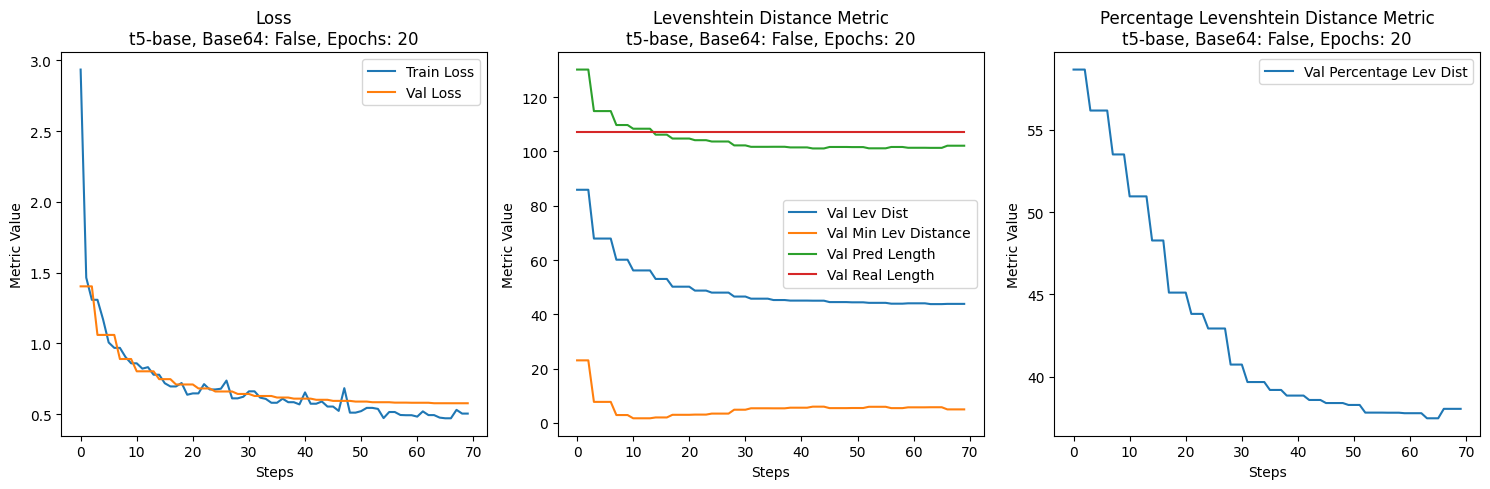

In [ ]:
# plot validation metrics
plot_validation_data(history, model_checkpoint, BASE64, EPOCHS)

In [ ]:
# test the model
trainer.test(model, dataset)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric            ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_lev_dist           │         43.27799987792969         │
│             test_loss             │        0.5695962905883789         │
│       test_max_lev_distance       │        107.34400177001953         │
│       test_min_lev_distance       │         5.144000053405762         │
│     test_percentage_lev_dist      │        37.321197509765625         │
│         test_pred_length          │        102.19999694824219         │
│ test_predicted_text_unzip_success │                0.0                │
│         test_real_length          │        107.34400177001953         │
│   test_true_text_unzip_success    │        0.8479999899864197         │
└───────────────────────────────────┴───────────────────────────────────┘

[{'test_loss': 0.5695962905883789,
  'test_lev_dist': 43.27799987792969,
  'test_pred_length': 102.19999694824219,
  'test_real_length': 107.34400177001953,
  'test_min_lev_distance': 5.144000053405762,
  'test_max_lev_distance': 107.34400177001953,
  'test_percentage_lev_dist': 37.321197509765625,
  'test_predicted_text_unzip_success': 0.0,
  'test_true_text_unzip_success': 0.8479999899864197}]

In [ ]:
finished_run = api.run(run_path)

while not any(col.startswith('test') for col in finished_run.history().columns):
    time.sleep(1)
    finished_run = api.run(run_path)

# get the history of the run as a pandas DataFrame of the logged metrics
history = finished_run.history()
clean_history(history)

In [ ]:
# show the columns of the wandb run
print(history.columns)

if (TEST):
    for metric_name in history.columns:
        if metric_name.startswith('test'):
            history[metric_name] = history[metric_name].mean()
        print(f"{metric_name}:")
        print(history[metric_name].values)

Index(['trainer/global_step', '_step', 'train_loss', '_runtime', 'epoch',
       '_timestamp', 'val_true_text_unzip_success', 'val_real_length',
       'val_min_lev_distance', 'val_max_lev_distance', 'val_lev_dist',
       'val_pred_length', 'val_percentage_lev_dist', 'val_loss',
       'val_predicted_text_unzip_success', 'test_real_length',
       'test_true_text_unzip_success', 'test_max_lev_distance',
       'test_min_lev_distance', 'test_lev_dist', 'test_percentage_lev_dist',
       'test_pred_length', 'test_loss', 'test_predicted_text_unzip_success'],
      dtype='object')


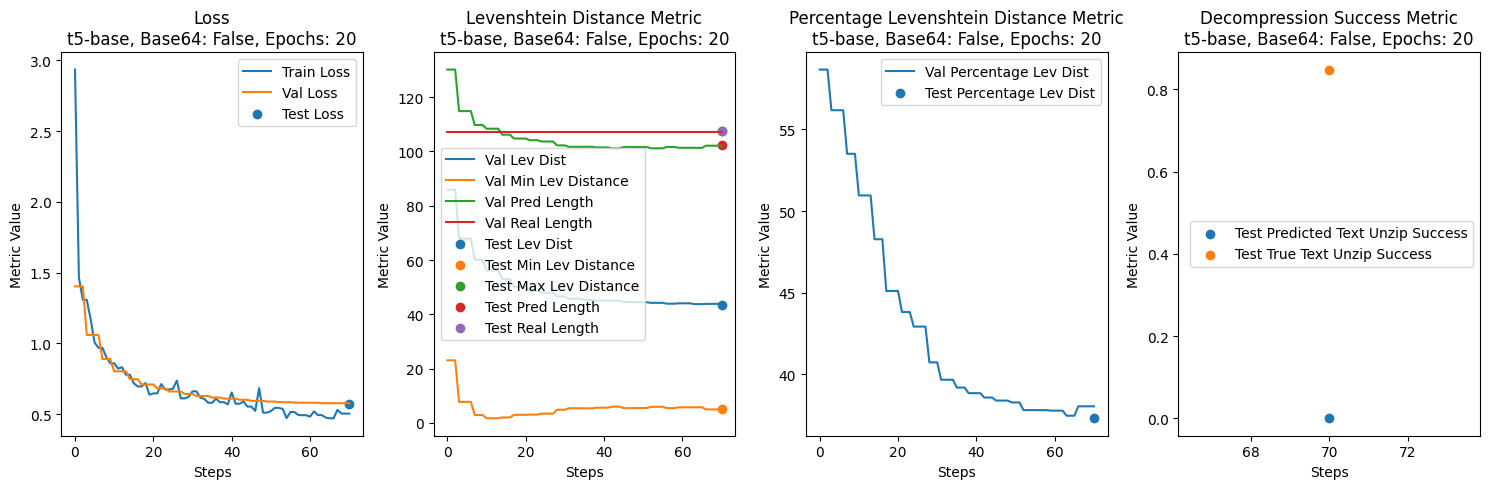

In [ ]:
# plot validation and test metrics
plot_test_data(history, model_checkpoint, BASE64, EPOCHS)

In [ ]:
# finish the wandb run
wandb.finish()

In [ ]:
# show the contents of the output file
!cat output1.txt

Predicted Text, True Text
x\x9csxf3\\xcc\-xccS\\,VH\)xc9\xc9+xc9+xcc\Q(JV-R\xc0\\xcdL\xc9\xcc+\\x00\\x00\x00\x0\x0e\xac					x\x9c\xf3M\xccK\xcfIT(O,V(.\xcd\xcd\xcd\xcfKMQHL+I-R\xf0ML\xc9(\xcd\xcd,IT\x07Je\x02\x000\x97\x0e\xc6
x\x9c\\\.xc9\xcc\\xcL\xc9\\R\xc8HxccS\\\\xccTxc/xcc\p\\xcc\\\xc9H\Q\xc8\xcc\\\xc\x002\x002\x00\\x0\x0e\xb6					x\x9cs,-\xc9\xc8/\xca,\xc9L-V\xc8\xccSp*J\xac\xca\xccQ(N\xacT(\xc9H,Q\xc8\xcd/J\x05\xb1\xf2\x005\x17\x0e\xe9
x\x9csT(xc8\\R\\xcd\\\xcaT\Vxca\\Q\\xcd\\xc9\,\xcd\(\xc9HU(\xc9HUH\,Vxc\xcf\xc9\xc\x00\\xd\x0e\x0"					x\x9csT\xc8M-JN\xcdK,\xaaTH/\xca/-PHK\xcc,\xc9H+\xcdQ(\xc9W(\xc9HU(O,\xca\xcd\xcf\x03\x00/\x05\x0f\x00
x\x9c\x0b\xc9HU\\-xca\\xc9\\xc\\xccK\V\\xc9\\\\xc9H\\\xcc\\\xca6Q\\\\\xcd\\xc\xc\x00"\x02\x0e\					x\x9c\x0b\xc9HUp*\xca,\xc9,\xcePH\xccMJ,.NL\xc9/R(\xc9WpM\xaf,(\xd1QpI-J\xcdV\x08\x00\x00(\xed\x0e'
x\x9c\x0b\xc9HU\xce\xcf\H\.\xc9\xcc\\\Q\\xcc\Qxcec\xcf\xccS\(\\xc\\V\-xc9\xcc\xcf\\\\\xc\x00\\xb2\x0e\\					x\x9c\x0b\xc9L\xca\xcfKUH-.\xc9\xccM,IMQH

In [ ]:
CURRENT_ROWS = 0

## Baseline

In [ ]:
class MyBaselineDataModule(LightningDataModule):
    def __init__(self, model_name_or_path, texts, compressed_texts, max_length=MAX_LENGTH):
        self.model_name_or_path = model_name_or_path
        self.texts = texts
        self.compressed_texts = compressed_texts
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name_or_path, use_fast=True)
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        compressed_text = self.compressed_texts[idx]

        inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        labels = self.tokenizer(compressed_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length).input_ids

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

In [ ]:
class MyBaseline(LightningModule):

    def __init__(self, model_name_or_path, vocab_size: int, embedding_dim: int, hidden_dim: int, learning_rate: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.loss = nn.CrossEntropyLoss()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        output, _ = self.rnn(embedded)
        logits = self.fc(output)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids, labels = batch['input_ids'], batch['labels']
        logits = self(input_ids)
        loss = self.loss(logits.view(-1, logits.size(-1)), labels.view(-1))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, labels = batch['input_ids'], batch['labels']
        logits = self(input_ids)
        val_loss = self.loss(logits.view(-1, logits.size(-1)), labels.view(-1))
        self.log('val_loss', val_loss)

        predicted_ids = torch.argmax(logits, dim=-1) # num_tokens
        predicted_text = self.tokenizer.batch_decode(predicted_ids, skip_special_tokens=BASE64)
        true_text = self.tokenizer.batch_decode(batch['labels'], skip_special_tokens=BASE64)

        if(TEST):
            print("predicted_text\n",predicted_text)
            print("true_text\n",true_text)


        # post process the predicted and true text
        predicted_text, true_text = postprocess_data(predicted_text, true_text)

        # compute the Levenshtein distance and associated metrics
        lev_dist, pred_length, real_length, min_lev_distance, max_lev_distance, percentage_lev_dist = levenshtein_distance(predicted_text, true_text)
        self.log('val_lev_dist', lev_dist)
        self.log('val_pred_length', pred_length)
        self.log('val_real_length', real_length)
        self.log('val_min_lev_distance',min_lev_distance)
        self.log('val_max_lev_distance',max_lev_distance)
        self.log('val_percentage_lev_dist',percentage_lev_dist)

        # compute the unzip metric
        predicted_text_unzip_success, true_text_unzip_success = unzip_metric(predicted_text, true_text)
        self.log('val_predicted_text_unzip_success', predicted_text_unzip_success)
        self.log('val_true_text_unzip_success', true_text_unzip_success)

    def test_step(self, batch, batch_idx):
        input_ids, labels = batch['input_ids'], batch['labels']
        logits = self(input_ids)
        test_loss = self.loss(logits.view(-1, logits.size(-1)), labels.view(-1))
        self.log('test_loss', test_loss)

        predicted_ids = torch.argmax(logits, dim=-1) # num_tokens
        predicted_text = self.tokenizer.batch_decode(predicted_ids, skip_special_tokens=BASE64)
        true_text = self.tokenizer.batch_decode(batch['labels'], skip_special_tokens=BASE64)

        if(TEST):
            print("predicted_text\n",predicted_text)
            print("true_text\n",true_text)

        # post process the predicted and true text
        predicted_text, true_text = postprocess_data(predicted_text, true_text)

        # write the pairs of predicted and true text into an output file
        global CURRENT_ROWS
        if (CURRENT_ROWS < TOTAL_ROWS):
            for i in range(len(predicted_text)):
                if (CURRENT_ROWS < TOTAL_ROWS):
                    write_to_file(predicted_text[i], true_text[i])
                CURRENT_ROWS += 1

        # compute the Levenshtein distance and associated metrics
        lev_dist, pred_length, real_length, min_lev_distance, max_lev_distance, percentage_lev_dist = levenshtein_distance(predicted_text, true_text)
        self.log('test_lev_dist', lev_dist)
        self.log('test_pred_length', pred_length)
        self.log('test_real_length', real_length)
        self.log('test_min_lev_distance',min_lev_distance)
        self.log('test_max_lev_distance',max_lev_distance)
        self.log('test_percentage_lev_dist',percentage_lev_dist)

        # compute the unzip metric
        predicted_text_unzip_success, true_text_unzip_success = unzip_metric(predicted_text, true_text)
        self.log('test_predicted_text_unzip_success', predicted_text_unzip_success)
        self.log('test_true_text_unzip_success', true_text_unzip_success)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [ ]:
# initialize the dataset using the other datamodule
dataset = datasets.load_dataset("glue", "rte")

train_texts = dataset["train"]["sentence1"]
train_texts = [s[:40] for s in train_texts]
val_texts = dataset["validation"]["sentence1"]
val_texts = [s[:40] for s in val_texts]
test_texts = dataset["test"]["sentence1"]
test_texts = [s[:40] for s in test_texts]

if (BASE64):
  train_compressed_texts = [str(base64.b64encode(zlib.compress(s.encode(), 9)).decode()) for s in train_texts]
  val_compressed_texts = [str(base64.b64encode(zlib.compress(s.encode(), 9)).decode()) for s in val_texts]
  test_compressed_texts = [str(base64.b64encode(zlib.compress(s.encode(), 9)).decode()) for s in test_texts]

if (not BASE64):
  train_compressed_texts = [str(zlib.compress(s.encode('utf-8'))) for s in train_texts]
  val_compressed_texts = [str(zlib.compress(s.encode('utf-8'))) for s in val_texts]
  test_compressed_texts = [str(zlib.compress(s.encode('utf-8'))) for s in test_texts]

train_dataset = MyBaselineDataModule(model_checkpoint, train_texts, train_compressed_texts)
val_dataset = MyBaselineDataModule(model_checkpoint, val_texts, val_compressed_texts)
test_dataset = MyBaselineDataModule(model_checkpoint, test_texts, test_compressed_texts)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=AVAILABLE_CPUS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=AVAILABLE_CPUS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=AVAILABLE_CPUS)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
# initialize the model
model = MyBaseline(model_name_or_path=model_checkpoint, vocab_size=train_dataset.tokenizer.vocab_size, embedding_dim=1024, hidden_dim=512)

In [ ]:
# initialize the wandb run
EPOCHS = 100
now = str(datetime.now())
run = wandb.init(project= "Deep Learning Project",
      name= "TEST"+now,
      config={
      "learning_rate": model.hparams.learning_rate,
      "dataset": "GLUE",
      "base64": BASE64,
      "epochs": EPOCHS,
      #"train batch size": model.hparams.train_batch_size,
      #"eval batch size": model.hparams.eval_batch_size
      })

In [ ]:
# log model checkpoints created during training
wandb_logger = WandbLogger(log_model="all")

# initialize the trainer
trainer = Trainer(max_epochs=EPOCHS,
    deterministic=True,
    check_val_every_n_epoch=1,
    precision="16-mixed",
    accelerator="auto",
    callbacks=[checkpoint_callback2, print_loss_callback],
    logger=wandb_logger)

# create the output file
output_file = "output2.txt"
with open(output_file, 'w') as f:
    f.write("Predicted Text, True Text\n")

# train the model
trainer.fit(model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:390: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 32.9 M
1 | rnn       | GRU              | 2.4 M 
2 | fc        |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 0: 1.321735143661499


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 1: 1.2193522453308105


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 2: 1.2064391374588013


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 3: 1.3769328594207764


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 4: 1.106484055519104


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 5: 1.152908444404602


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 6: 1.137939691543579


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 7: 1.0224124193191528


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 8: 1.2051403522491455


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3120: 'val_loss' reached 1.24405 (best 1.24405), saving model to '/content/checkpoints/MyBaseline/epoch=9-step=3120.ckpt' as top 1


Average training loss at the end of epoch 9: 1.3175872564315796


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 10: 1.0901364088058472


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 11: 1.0800788402557373


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 12: 1.100732445716858


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 13: 1.1479376554489136


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 14: 1.0630236864089966


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 15: 1.0308434963226318


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 16: 1.1862359046936035


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 17: 1.0634570121765137


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 18: 1.0707448720932007


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 6240: 'val_loss' was not in top 1


Average training loss at the end of epoch 19: 1.2001450061798096


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 20: 1.1227977275848389


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 21: 1.118369221687317


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 22: 1.054088830947876


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 23: 1.08184015750885


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 24: 0.9392635822296143


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 25: 0.9196854829788208


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 26: 0.9991888403892517


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 27: 1.0471999645233154


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 28: 1.0656964778900146


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 9360: 'val_loss' was not in top 1


Average training loss at the end of epoch 29: 1.204046368598938


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 30: 1.0415245294570923


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 31: 1.1570206880569458


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 32: 1.01212739944458


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 33: 1.1363193988800049


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 34: 1.0246204137802124


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 35: 1.084305763244629


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 36: 1.0557326078414917


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 37: 0.9604125022888184


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 38: 1.0791640281677246


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 12480: 'val_loss' was not in top 1


Average training loss at the end of epoch 39: 1.0359244346618652


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 40: 1.003487229347229


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 41: 0.9095989465713501


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 42: 1.069242238998413


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 43: 0.9962276220321655


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 44: 1.0586042404174805


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 45: 1.042014479637146


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 46: 1.1224322319030762


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 47: 1.1177202463150024


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 48: 0.962390124797821


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 15600: 'val_loss' was not in top 1


Average training loss at the end of epoch 49: 1.0741076469421387


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 50: 1.0001827478408813


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 51: 1.0200623273849487


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 52: 1.0853370428085327


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 53: 0.9664356708526611


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 54: 1.0582221746444702


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 55: 0.8503947257995605


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 56: 0.9352907538414001


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 57: 0.892060399055481


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 58: 1.0164687633514404


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 18720: 'val_loss' was not in top 1


Average training loss at the end of epoch 59: 0.8649400472640991


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 60: 1.1446681022644043


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 61: 0.9262041449546814


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 62: 0.965704619884491


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 63: 1.0622743368148804


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 64: 1.0936689376831055


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 65: 0.9809352159500122


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 66: 0.9965571761131287


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 67: 1.1263847351074219


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 68: 1.010712742805481


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 21840: 'val_loss' was not in top 1


Average training loss at the end of epoch 69: 0.8798707723617554


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 70: 1.0120223760604858


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 71: 1.0009524822235107


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 72: 0.9821202754974365


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 73: 1.062165379524231


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 74: 1.000145435333252


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 75: 0.9385821223258972


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 76: 1.0263272523880005


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 77: 0.8238580822944641


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 78: 0.9927293658256531


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 24960: 'val_loss' was not in top 1


Average training loss at the end of epoch 79: 1.0236337184906006


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 80: 1.0080807209014893


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 81: 0.8991105556488037


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 82: 0.8422378301620483


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 83: 1.010887622833252


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 84: 0.968152642250061


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 85: 1.0503405332565308


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 86: 1.0119911432266235


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 87: 1.02536141872406


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 88: 1.0640290975570679


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 28080: 'val_loss' was not in top 1


Average training loss at the end of epoch 89: 0.9071457386016846


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 90: 0.9031802415847778


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 91: 0.921151340007782


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 92: 1.0468614101409912


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 93: 0.9529015421867371


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 94: 1.00335693359375


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 95: 0.9892427325248718


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 96: 0.9069851040840149


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 97: 1.0026235580444336


Validation: |          | 0/? [00:00<?, ?it/s]

Average training loss at the end of epoch 98: 0.8987585306167603


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 31200: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Average training loss at the end of epoch 99: 0.843801736831665


In [ ]:
# get the path of the best model and print it
model_path = checkpoint_callback2.best_model_path
print(model_path)

# load the best model
best_model = MyBaseline.load_from_checkpoint(model_path)

# now we can use the best model for inference
best_model.eval()

/content/checkpoints/MyBaseline/epoch=9-step=3120.ckpt


MyBaseline(
  (embedding): Embedding(32100, 1024)
  (rnn): GRU(1024, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=32100, bias=True)
  (loss): CrossEntropyLoss()
)

In [ ]:
# flag used to save the model on our Google Drive
SAVE_TO_DRIVE = False

if (SAVE_TO_DRIVE):
    drive.mount('/content/gdrive')

    # specify the destination path
    dest_path = '/content/gdrive/My Drive/'

    # copy the model from the current path to the destination path
    shutil.copy(model_path, dest_path)

In [ ]:
# check the wandb run path
api = wandb.Api()

run_path = run.path
print(run_path)
finished_run = api.run(run_path)

# get the history of the run as a pandas DataFrame of the logged metrics
history = finished_run.history()
clean_history(history)

prisco-1895709/Deep Learning Project/hztnvi4m


In [ ]:
# show the columns of the wandb run
print(history.columns)

if (TEST):
    for metric_name in history.columns:
        print(f"{metric_name}:")
        print(history[metric_name].values)

Index(['trainer/global_step', '_step', 'train_loss', '_runtime', 'epoch',
       '_timestamp', 'val_true_text_unzip_success', 'val_real_length',
       'val_min_lev_distance', 'val_max_lev_distance', 'val_lev_dist',
       'val_pred_length', 'val_percentage_lev_dist', 'val_loss',
       'val_predicted_text_unzip_success'],
      dtype='object')


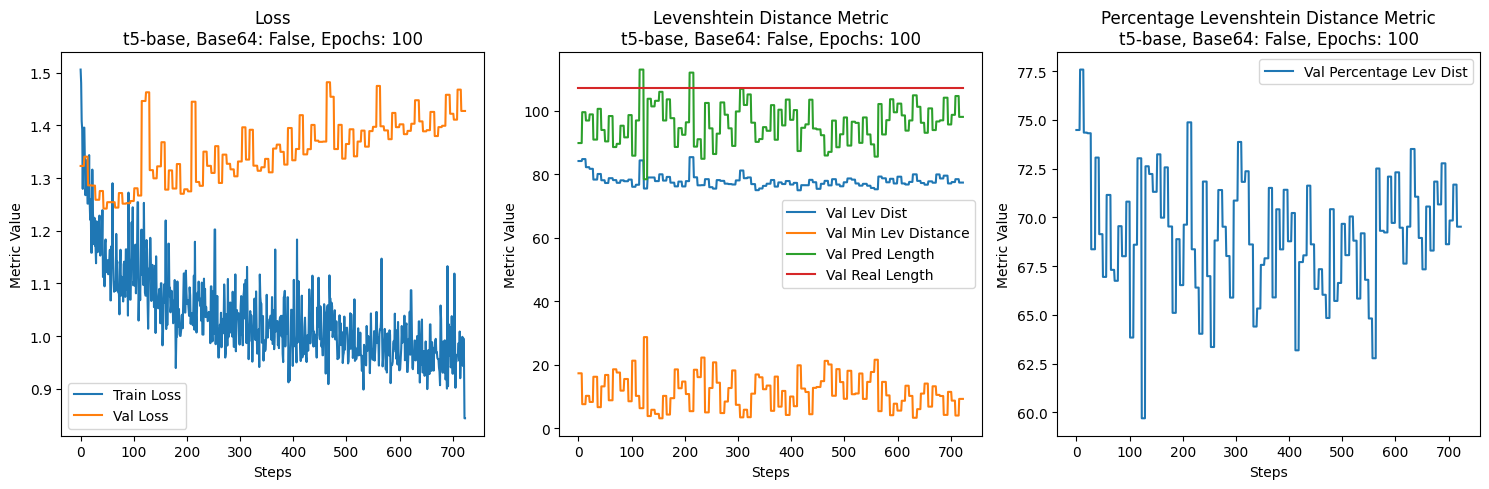

In [ ]:
# plot validation metrics
plot_validation_data(history, model_checkpoint, BASE64, EPOCHS)

In [ ]:
# test the model
trainer.test(model, test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric            ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_lev_dist           │         77.96600341796875         │
│             test_loss             │        1.4539889097213745         │
│       test_max_lev_distance       │         107.3949966430664         │
│       test_min_lev_distance       │         9.451000213623047         │
│     test_percentage_lev_dist      │         69.88566589355469         │
│         test_pred_length          │         98.09500122070312         │
│ test_predicted_text_unzip_success │                0.0                │
│         test_real_length          │        107.24400329589844         │
│   test_true_text_unzip_success    │        0.8516666889190674         │
└───────────────────────────────────┴───────────────────────────────────┘

[{'test_loss': 1.4539889097213745,
  'test_lev_dist': 77.96600341796875,
  'test_pred_length': 98.09500122070312,
  'test_real_length': 107.24400329589844,
  'test_min_lev_distance': 9.451000213623047,
  'test_max_lev_distance': 107.3949966430664,
  'test_percentage_lev_dist': 69.88566589355469,
  'test_predicted_text_unzip_success': 0.0,
  'test_true_text_unzip_success': 0.8516666889190674}]

In [ ]:
finished_run = api.run(run_path)

while not any(col.startswith('test') for col in finished_run.history().columns):
    time.sleep(1)
    finished_run = api.run(run_path)

# get the history of the run as a pandas DataFrame of the logged metrics
history = finished_run.history()
clean_history(history)

In [ ]:
# show the columns of the wandb run
print(history.columns)

if (TEST):
    for metric_name in history.columns:
        if metric_name.startswith('test'):
            history[metric_name] = history[metric_name].mean()
        print(f"{metric_name}:")
        print(history[metric_name].values)

Index(['trainer/global_step', '_step', 'train_loss', '_runtime', 'epoch',
       '_timestamp', 'val_true_text_unzip_success', 'val_real_length',
       'val_min_lev_distance', 'val_max_lev_distance', 'val_lev_dist',
       'val_pred_length', 'val_percentage_lev_dist', 'val_loss',
       'val_predicted_text_unzip_success', 'test_real_length',
       'test_true_text_unzip_success', 'test_max_lev_distance',
       'test_min_lev_distance', 'test_lev_dist', 'test_percentage_lev_dist',
       'test_pred_length', 'test_loss', 'test_predicted_text_unzip_success'],
      dtype='object')


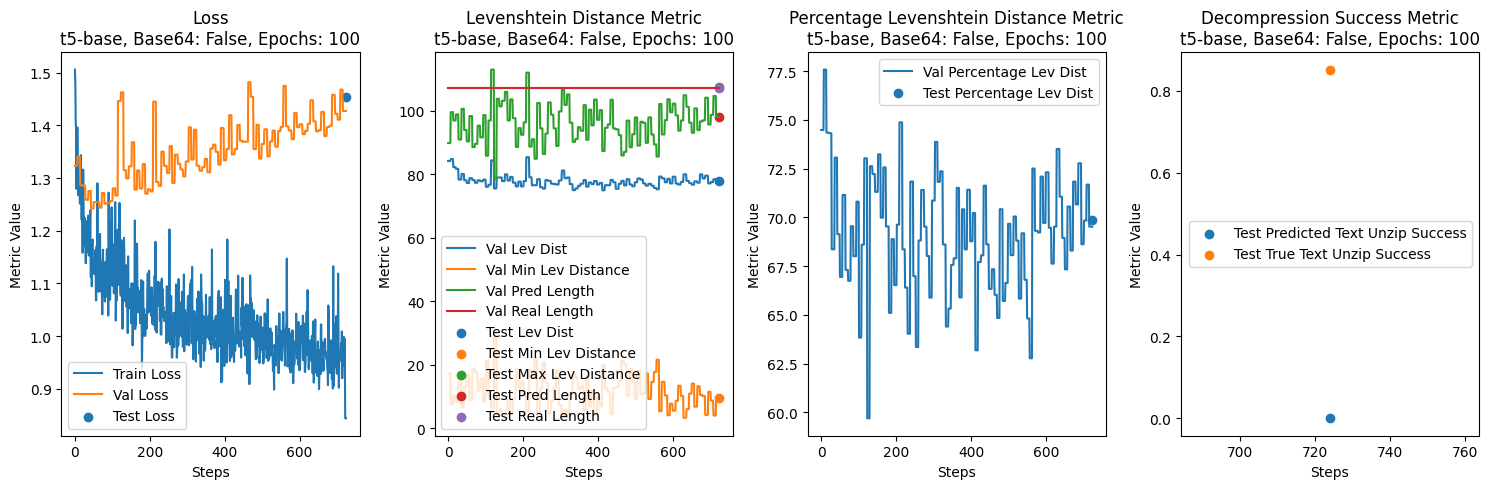

In [ ]:
# plot validation and test metrics
plot_test_data(history, model_checkpoint, BASE64, EPOCHS)

In [ ]:
# finish the wandb run
wandb.finish()

In [ ]:
# show the contents of the output file
!cat output2.txt

Predicted Text, True Text
x\xcc\ccx\x\xcccR\xcc\xcce\xcc\ccccccccxxx\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\					x\x9c\xf3M\xccK\xcfIT(O,V(.\xcd\xcd\xcd\xcfKMQHL+I-R\xf0ML\xc9(\xcd\xcd,IT\x07Je\x02\x000\x97\x0e\xc6
x\x9cs,\xccc\xcc\\ccccccccccccccccccccccccc\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\00\\\\\					x\x9cs,-\xc9\xc8/\xca,\xc9L-V\xc8\xccSp*J\xac\xca\xccQ(N\xacT(\xc9H,Q\xc8\xcd/J\x05\xb1\xf2\x005\x17\x0e\xe9
x\x9cs\x\cHH\xcdxxcc\xxxxxxx\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\c\\\\\\\\\\\\\\\\\\0000					x\x9csT\xc8M-JN\xcdK,\xaaTH/\xca/-PHK\xcc,\xc9H+\xcdQ(\xc9W(\xc9HU(O,\xca\xcd\xcf\x03\x00/\x05\x0f\x00
x\x9c\x0b\xc9HUHxc9PH\c9PH\cccccccccccccccc\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\xx					x\x9c\x0b\xc9HUp*\xca,\xc9,\xcePH\xccMJ,.NL\xc9/R(\xc9WpM\xaf,(\xd1QpI-J\xcdV\x08\x00\x00(\xed\x0e'
xx\x9c\x0b\\xcd\xc9\\xxxxxxxxxxxxaaaaaaaaaaaa\\\\\\\\\\\\\\\\\\\\\xxxx..\\\\\\\\\\xxxxxxx0					x\x9c\x0b\xc9L\xca\xcfKUH-.\xc9\xccM,IMQH\xc9L\xcc\xcd\xcfKQ((\xcaO)M.\xc9\xcc\xcfSH,

In [ ]:
CURRENT_ROWS = 0

## Performance Comparisons

In this final section, I plot the data relating to different runs I have completed, under different settings.

Run Path:  prisco-1895709/Deep Learning Project/zpnve0xl


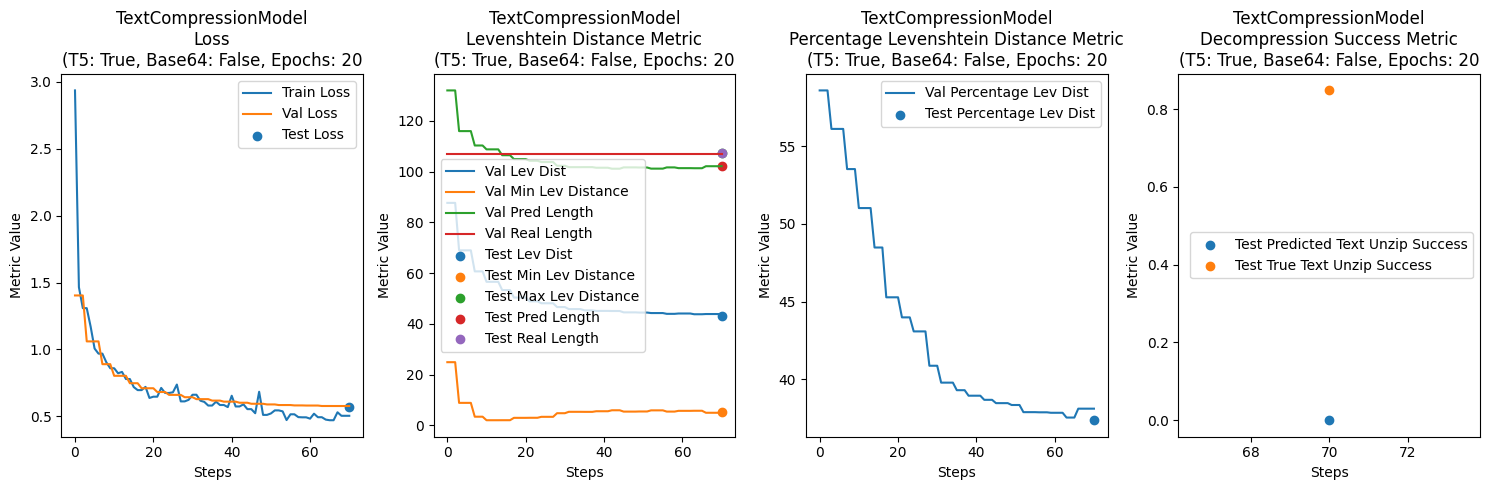

Run Path:  prisco-1895709/Deep Learning Project/snwtn2r9


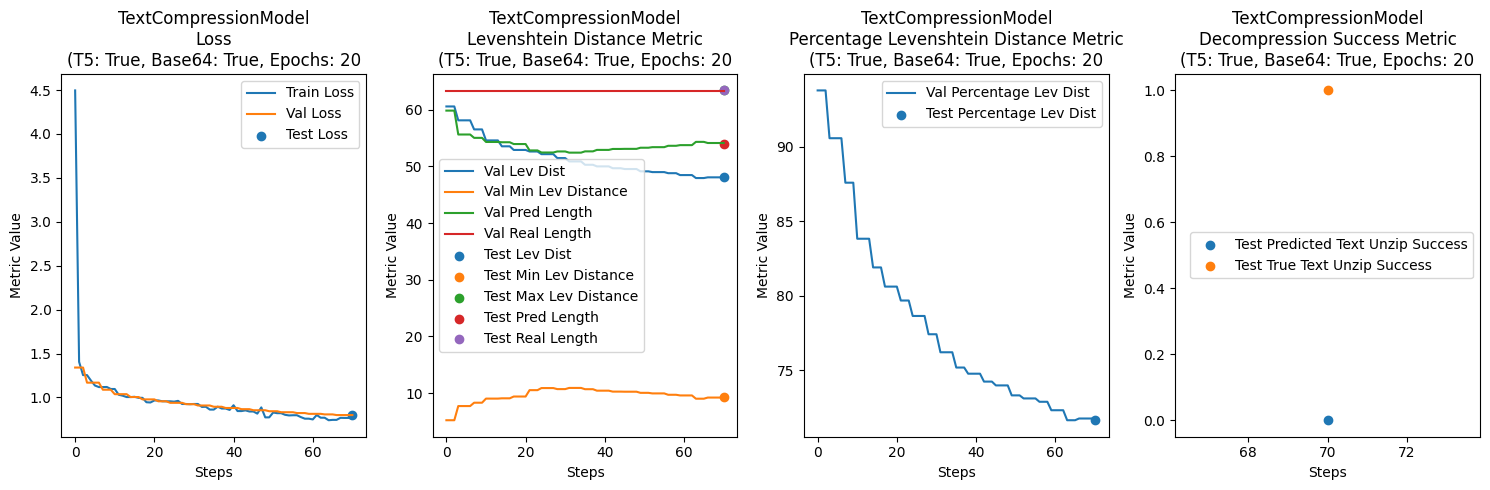

Run Path:  prisco-1895709/Deep Learning Project/0a52gmjb


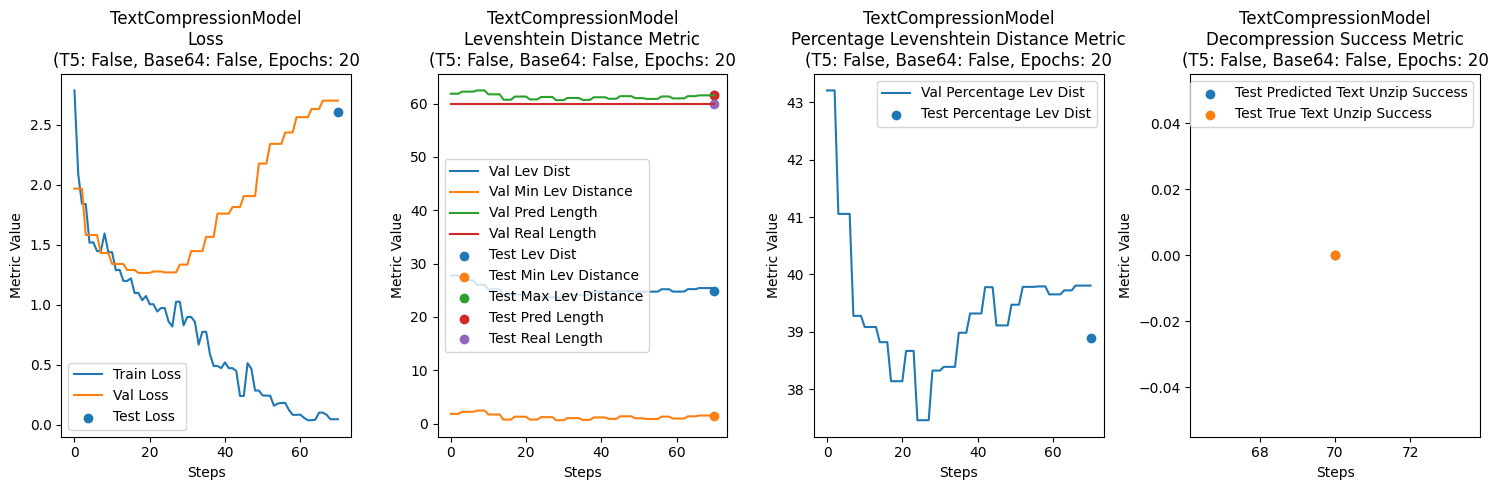

Run Path:  prisco-1895709/Deep Learning Project/gmleex66


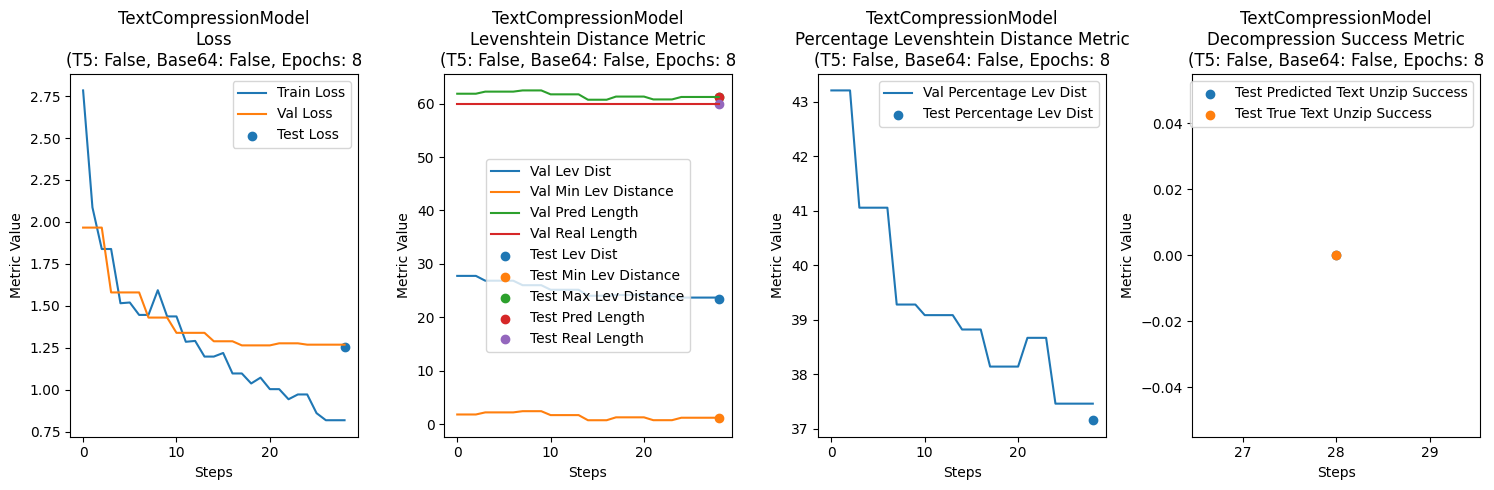

Run Path:  prisco-1895709/Deep Learning Project/5775rsz2


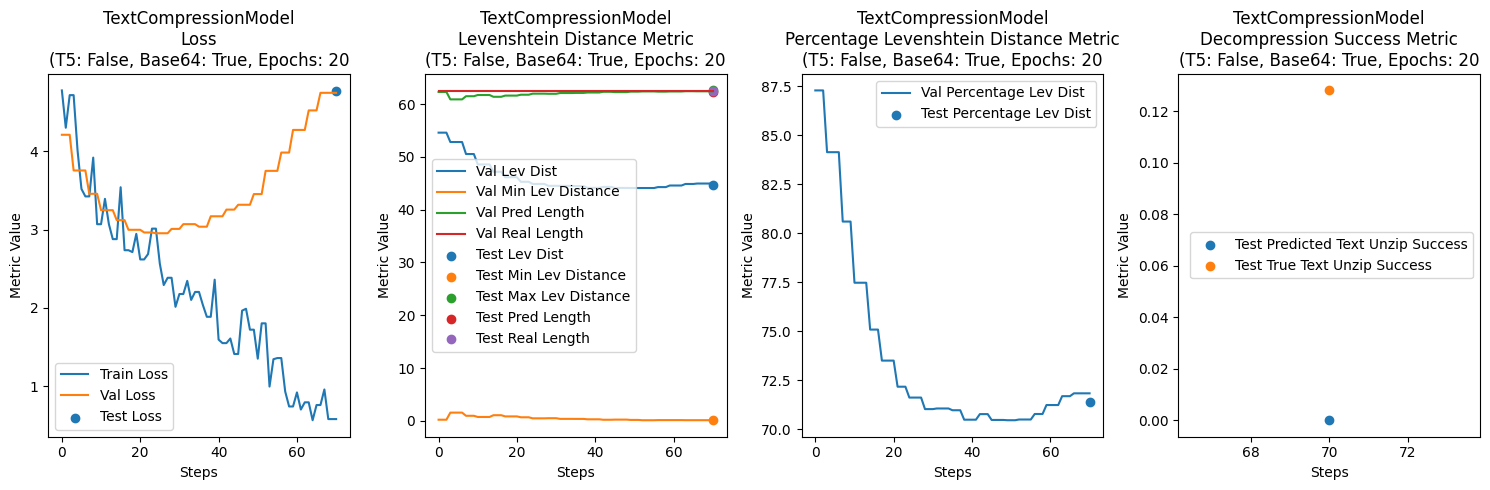

Run Path:  prisco-1895709/Deep Learning Project/1gipbrl2


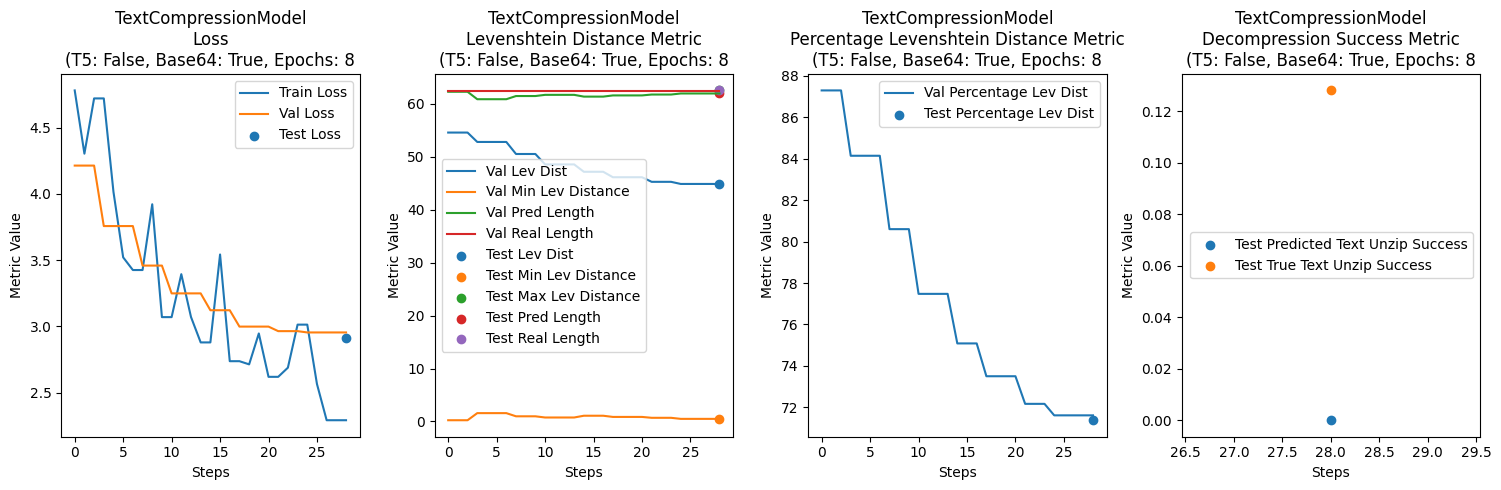

Run Path:  prisco-1895709/Deep Learning Project/lx42qzg0


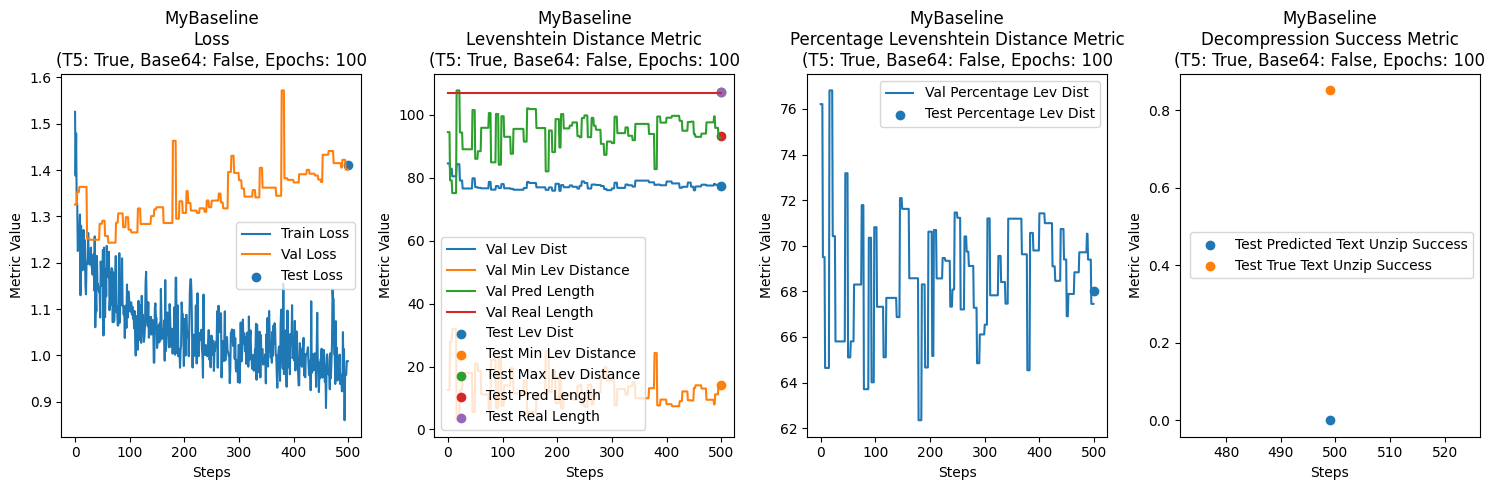

Run Path:  prisco-1895709/Deep Learning Project/dvabujs9


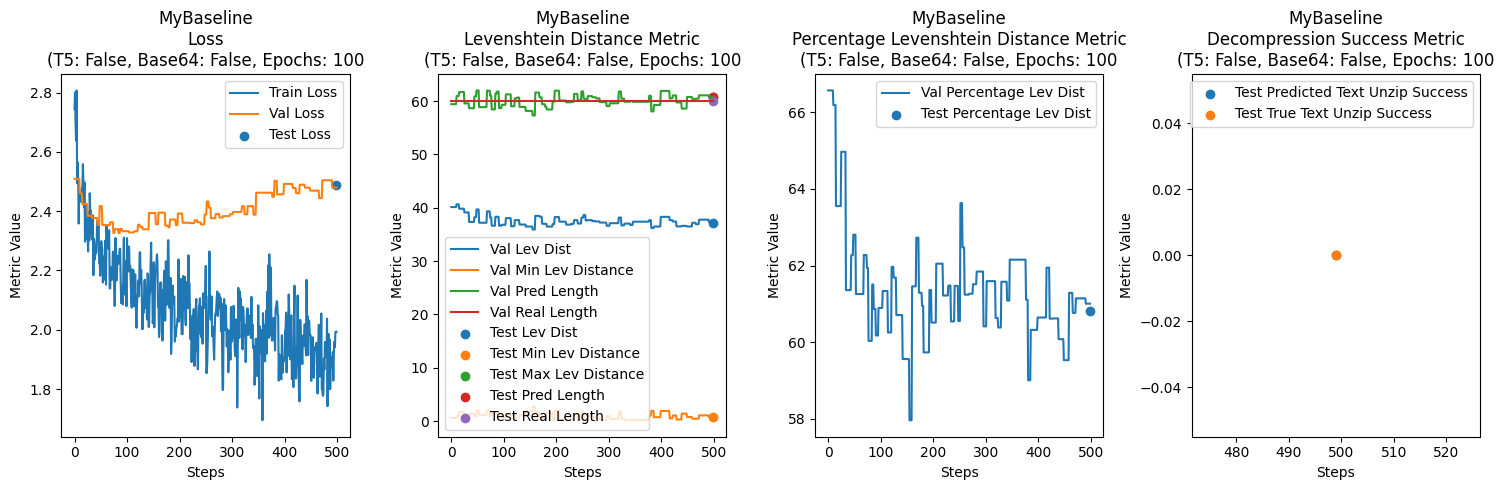

Run Path:  prisco-1895709/Deep Learning Project/q9yil3qu


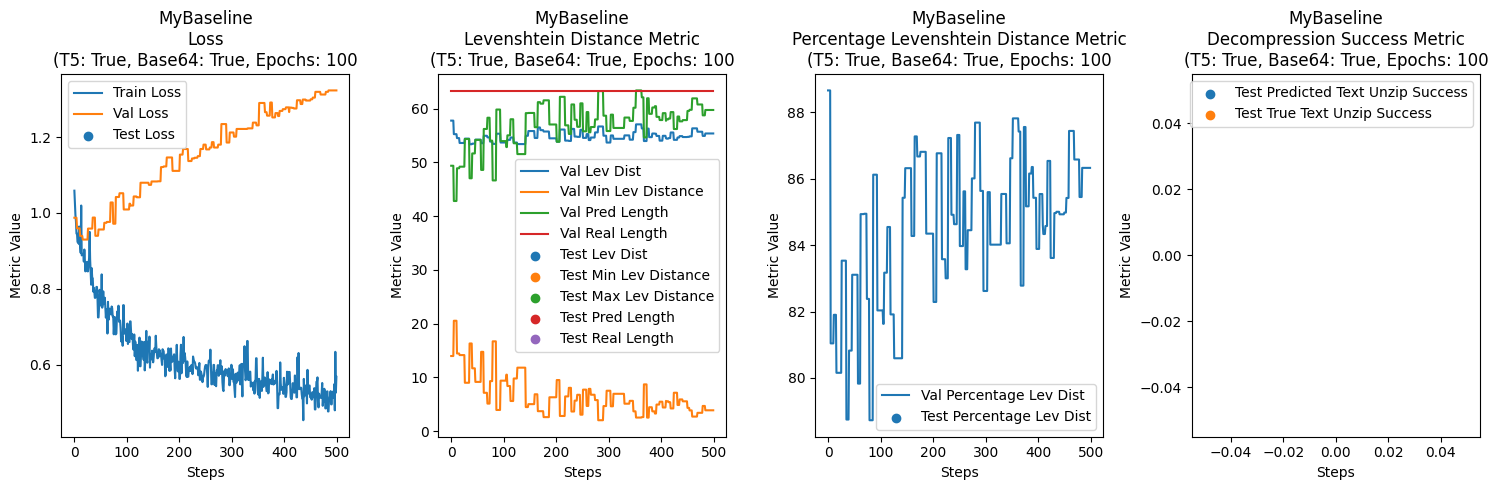

Run Path:  prisco-1895709/Deep Learning Project/hi9ezlry


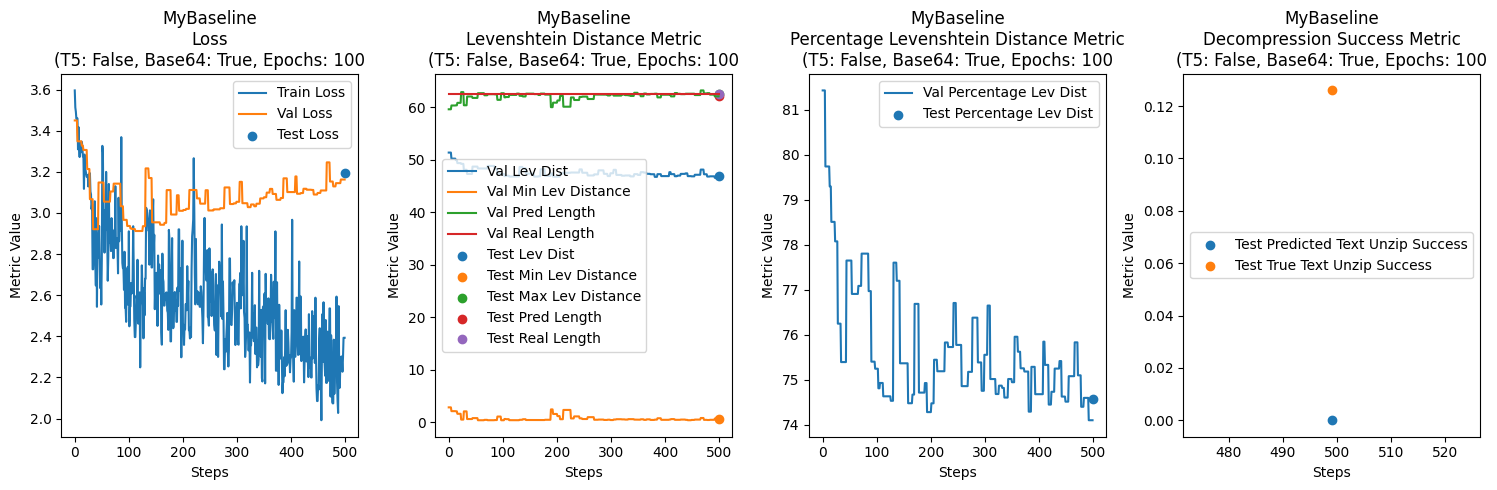

In [ ]:
prefix = "prisco-1895709/Deep Learning Project/"

run_ids = ["zpnve0xl", "snwtn2r9", "0a52gmjb", "gmleex66", "5775rsz2", "1gipbrl2", "lx42qzg0", "dvabujs9", "q9yil3qu", "hi9ezlry"]

additional_info = {
    "zpnve0xl": {"model": "TextCompressionModel", "t5": True, "base64": False, "epochs": 20},
    "snwtn2r9": {"model": "TextCompressionModel", "t5": True, "base64": True, "epochs": 20},
    "0a52gmjb": {"model": "TextCompressionModel", "t5": False, "base64": False, "epochs": 20},
    "gmleex66": {"model": "TextCompressionModel", "t5": False, "base64": False, "epochs": 8},
    "5775rsz2": {"model": "TextCompressionModel", "t5": False, "base64": True, "epochs": 20},
    "1gipbrl2": {"model": "TextCompressionModel", "t5": False, "base64": True, "epochs": 8},
    "lx42qzg0": {"model": "MyBaseline", "t5": True, "base64": False, "epochs": 100},
    #"kmqecx8h": {"model": "MyBaseline", "t5": True, "base64": False, "epochs": 100}, # add "kmqecx8h", in the run_ids if you want to still use this run
    "dvabujs9": {"model": "MyBaseline", "t5": False, "base64": False, "epochs": 100},
    "q9yil3qu": {"model": "MyBaseline", "t5": True, "base64": True, "epochs": 100}, # maybe repeat this run
    "hi9ezlry": {"model": "MyBaseline", "t5": False, "base64": True, "epochs": 100},

}

groups = {
    "Loss": ["train_loss", "val_loss", "test_loss"],
    "Levenshtein Distance Metric": ["val_lev_dist", "val_min_lev_distance", "val_pred_length", "val_real_length", "test_lev_dist", "test_min_lev_distance", "test_max_lev_distance", "test_pred_length", "test_real_length"],
    "Percentage Levenshtein Distance Metric": ["val_percentage_lev_dist", "test_percentage_lev_dist"],
    "Decompression Success Metric": ["test_predicted_text_unzip_success", "test_true_text_unzip_success"]
}

api = wandb.Api()

for run_id in run_ids:
    run_path = prefix + run_id
    print("Run Path: ", run_path)

    run = api.run(run_path)
    history = run.history()
    clean_history(history)

    # create a separate plot for each group
    fig, axs = plt.subplots(1, len(groups), figsize=(15, 5))
    for ax, (group_name, metric_names) in zip(axs, groups.items()):
        for metric_name in metric_names:
            if metric_name in history.columns:
                if not metric_name.startswith('test'):
                    ax.plot(history[metric_name], label=metric_name.replace('_', ' ').title())
                else:
                    ax.scatter(len(history[metric_name])-1, history[metric_name].mean(), label=metric_name.replace('_', ' ').title())
        model_checkpoint = additional_info[run_id]["model"].replace("google/", "")
        ax.set_title(f'{additional_info[run_id]["model"]}\n{group_name}\n(T5: {additional_info[run_id]["t5"]}, Base64: {additional_info[run_id]["base64"]}, Epochs: {additional_info[run_id]["epochs"]}')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Metric Value')
        ax.legend()
        ax.legend()
    plt.tight_layout()
    plt.show()

# Special Section - Outside the scope of the Project

This section is NOT intended to be part of the final working project, it only includes some attempts and data manipulations that have been done before chosing the ones appearing in the working code.

Thus, this section is NOT intended to be executed,

In [ ]:
model_checkpoint = "t5-base"

if (False):
  dataset = datasets.load_dataset("glue", "rte")
  texts = dataset["train"]["sentence1"][:1000]
  #texts = dataset["train"]["sentence1"]
  #print("TEXT\n", texts)

  #compressed_text = zip(text)
  #print("ZIP:\n", str(compressed_text))

  compressed_texts = str(zlib.compress(texts[i].encode('utf-8')) for i in texts)
  compressed_texts = [str(zlib.compress(s.encode('utf-8'))) for s in texts]
  #print("COMPRESSED TEXT:\n", compressed_texts)

  #decompressed_text = zlib.decompress(compressed_text)
  #print("DECOMPRESSED TEXT:\n", decompressed_text)
  #print(type(compressed_text))

  #inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
  #labels = self.tokenizer(compressed_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length).input_ids

  dataset = TextCompressionDataModule1(model_checkpoint, texts, compressed_texts)

  train_size = int(0.6 * len(dataset))
  val_size = int(0.2 * len(dataset))
  test_size = len(dataset) - train_size - val_size
  train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
  train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=8)
  test_dataloader = DataLoader(test_dataset, batch_size=8)

##################   TEST FOR BASE 64 E ZLIB   ###########################

if (False):
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

  train_texts = dataset["test"]["sentence1"][:1000]
  train_texts = [s[:40] for s in train_texts]

  if (BASE64):
    train_compressed_texts = [str(base64.b64encode(zlib.compress(s.encode(), 9)).decode()) for s in train_texts]

  if (not BASE64):
    train_compressed_texts = [str(zlib.compress(s.encode('utf-8'))) for s in train_texts]


  print("train_texts\n",train_texts)
  print("train_compressed_texts\n",train_compressed_texts)

  encoded_texts = tokenizer.batch_encode_plus(train_compressed_texts, return_tensors='pt', padding='max_length', truncation=True, max_length=256)
  #print("encoded_texts\n",encoded_texts)

  #print("features\n",features)
  #print("labels\n",labels)

  decoded_texts = tokenizer.batch_decode(encoded_texts['input_ids'], skip_special_tokens=BASE64)
  print("decoded_texts\n",decoded_texts)

  if (BASE64):
    changed_decoded_text = decoded_texts

  if (not BASE64):
    changed_decoded_text = [s.replace("<unk> ", '\\') for s in decoded_texts]
    changed_decoded_text = [s.replace("</s>", "") for s in changed_decoded_text]
    changed_decoded_text = [s.replace("<pad>", "") for s in changed_decoded_text]
    changed_decoded_text = [s.replace("b'", "") for s in changed_decoded_text]
    changed_decoded_text = [s.replace("'", '') for s in changed_decoded_text]
    #changed_decoded_text = [s[2:-1] for s in changed_decoded_text]

  print("changed_decoded_text\n",changed_decoded_text)

  if (BASE64):
    for i in range(len(changed_decoded_text)):

      #print("original_length", len(train_texts[i]))
      #print("encoded_texts_length", len(encoded_texts['input_ids'][i]))
      #print("decoded_texts_length", len(decoded_texts[i]))

      length = len(changed_decoded_text[i])
      new_length = length - (length % 4)
      changed_decoded_text[i] = changed_decoded_text[i][:new_length]

  if (BASE64):
    decompressed_texts = [str(zlib.decompress(base64.b64decode(s.encode())).decode()) for s in changed_decoded_text]

  if (not BASE64):
    import ast
    decompressed_texts = []
    for i in range(len(changed_decoded_text)):
      try:
        #print(changed_decoded_text[i])
        decompressed_text = str(zlib.decompress(ast.literal_eval("b'"+changed_decoded_text[i]+"'")).decode('utf-8'))
        decompressed_texts.append(decompressed_text)
        #print(decompressed_texts)
      except Exception as e:
        x = 0
    #decompressed_texts = [str(zlib.decompress(ast.literal_eval("b'"+changed_decoded_text[i]+"'"))) for i in range(len(changed_decoded_text))]

  print("decompressed_text",decompressed_texts)